In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
from datetime import datetime
from tqdm import tqdm_notebook
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
%matplotlib inline
mydpi=600
b=False
s=18

aggregation='mean'
orange, purple, elm, grey ='#FFCC00', '#666599', '#217C7E', '#F5F5F5'
c =[ "#f4f4f4", "#f4f4f4", "#f4f4f4", "#f4f4f4", "#ffffff", "#f4f4f4", "#f4f4f4", "#ffffff", "#f4f4f4", 
     "#f4f4f4", "#ffffff", "#f4f4f4", "#f4f4f4","#ffffff", "#f4f4f4", "#f4f4f4", "#ffffff"] 

__author__ = 'HK Dambanemuya'
__version__ = 'Python3'

In [2]:
print ("Reading News...")
news = pd.read_csv('../Data/Fusion/news.csv')
news = news[news['length']>100]
news['date'] = [datetime.strftime(date, '%Y-%m-%d') for date in tqdm_notebook(pd.to_datetime(news['date']))]

print ("Reading Blogs...")
blogs = pd.read_csv('../Data/Fusion/blogs.csv')
blogs = blogs[blogs['length']>100]
blogs['date'] = [datetime.strftime(date, '%Y-%m-%d') for date in tqdm_notebook(pd.to_datetime(blogs['date']))]

print ("Reading Discussions...")
discussions = pd.read_csv('../Data/Fusion/discussions.csv')
discussions = discussions[discussions['length']>100]
discussions['date'] = [datetime.strftime(date, '%Y-%m-%d') for date in tqdm_notebook(pd.to_datetime(discussions['date']))]

Reading News...



Reading Blogs...



Reading Discussions...


In [3]:
# Select countries common in all 3 data sets
country_map = Counter(set(news['country']))+Counter(set(blogs['country']))+Counter(set(discussions['country']))
common_locations = []
for k,v in tqdm_notebook(country_map.items()):
    if (v == 3) and (k==k):
        common_locations.append(k)
print("Common Countries:", len(common_locations))


Common Countries: 79


In [4]:
# Filter data by common countries
news = news[news['country'].isin(common_locations)]
blogs = blogs[blogs['country'].isin(common_locations)]
discussions = discussions[discussions['country'].isin(common_locations)]
print ("News:", len(news))
print ("Blogs:", len(blogs))
print ("Discussions:", len(discussions))

News: 2277563
Blogs: 946755
Discussions: 409091


In [5]:
# Get daily aggregated data
news_ = news.groupby('date').agg(aggregation)
blogs_ = blogs.groupby('date').agg(aggregation)
discussions_ = discussions.groupby('date').agg(aggregation)
# Get unique dates for all data
dates = sorted(list(set(news_.index).union(set(blogs_.index)).union(set(discussions_.index))))[1:-1]
dates_ = [date[5:] for date in dates]

In [6]:
def get_polarity(dates=dates, polarity="sentiment", rolling=True, window=5):
    news_polarity, blogs_polarity, discussions_polarity = [], [], []

    for date in dates:
        # News Sentiment
        if news_[news_.index == date][polarity].values:
            news_polarity.append(news_[news_.index == date][polarity].values[0])
        else:
            news_polarity.append(0)
        # Blogs Sentiment
        if blogs_[blogs_.index == date][polarity].values:
            blogs_polarity.append(blogs_[blogs_.index == date][polarity].values[0])
        else:
            blogs_polarity.append(0)
        # Discussions Sentiment  
        if discussions_[discussions_.index == date][polarity].values:    
            discussions_polarity.append(discussions_[discussions_.index ==date][polarity].values[0])
        else:
            discussions_polarity.append(0)
    if rolling:
        news_rolling_polarity = pd.Series(news_polarity).fillna(0).rolling(window, win_type='triang').mean()
        blogs_rolling_polarity= pd.Series(blogs_polarity).fillna(0).rolling(window, win_type='triang').mean()
        discussions_rolling_polarity = pd.Series(discussions_polarity).fillna(0).rolling(window, win_type='triang').mean()
    
        assert len(news_rolling_polarity) == len(blogs_rolling_polarity) == len(discussions_rolling_polarity)
        n= len(news_rolling_polarity)
        return news_rolling_polarity, blogs_rolling_polarity, discussions_rolling_polarity, n
    
    else:
        assert len(news_polarity) == len(blogs_polarity) == len(discussions_polarity)
        n= len(news_polarity)
        return news_polarity, blogs_polarity, discussions_polarity
   

In [7]:
print ("News (Mean, STD):", news['sentiment'].mean(), news['sentiment'].std())
print ("Blogs (Mean, STD):", blogs['sentiment'].mean(), blogs['sentiment'].std())
print ("Discussions (Mean, STD):", discussions['sentiment'].mean(), discussions['sentiment'].std())

News (Mean, STD): 0.21449215284053244 0.8372244533123548
Blogs (Mean, STD): 0.2758772959213135 0.8282866817768114
Discussions (Mean, STD): 0.006251372921915904 0.8101476646256769


In [8]:
theme_map = {"medical supplies": ['medical supplies', 'test kits'],
             "ppe": ['face mask', 'hand sanitizer'],
             "recommendations": ['shelter in place', 'social distancing'],
             "restrictions": ['school closure', 'travel ban'],
             "seasonal flu": ['common cold', 'flu']
            }

In [9]:
def get_sentiment(theme_map):
    
    sources = ['News', 'Blogs', 'Discussions']*(len(theme_map)*3)
    topics_ = []
    sentiment = []
    
    for theme, topics in tqdm_notebook(theme_map.items()):
        
        topics_.extend([theme]*3)
    
        sentiment.extend([news[news['theme'].str.contains(theme)]['sentiment'].mean(),
                       blogs[blogs['theme'].str.contains(theme)]['sentiment'].mean(),
                       discussions[discussions['theme'].str.contains(theme)]['sentiment'].mean()])
        
        topics_.extend([topics[0]]*3)
    
        sentiment.extend([news[news['topic'].str.contains(topics[0])]['sentiment'].mean(),
                       blogs[blogs['topic'].str.contains(topics[0])]['sentiment'].mean(),
                       discussions[discussions['topic'].str.contains(topics[0])]['sentiment'].mean()])
        
        topics_.extend([topics[1]]*3)
    
        sentiment.extend([news[news['topic'].str.contains(topics[1])]['sentiment'].mean(),
                       blogs[blogs['topic'].str.contains(topics[1])]['sentiment'].mean(),
                       discussions[discussions['topic'].str.contains(topics[1])]['sentiment'].mean()])
    
    df = pd.DataFrame()
    df['topics'] = topics_
    df['Source'] = sources
    df['Sentiment'] = sentiment
    
    return df

In [10]:
sentiment_df = get_sentiment(theme_map)

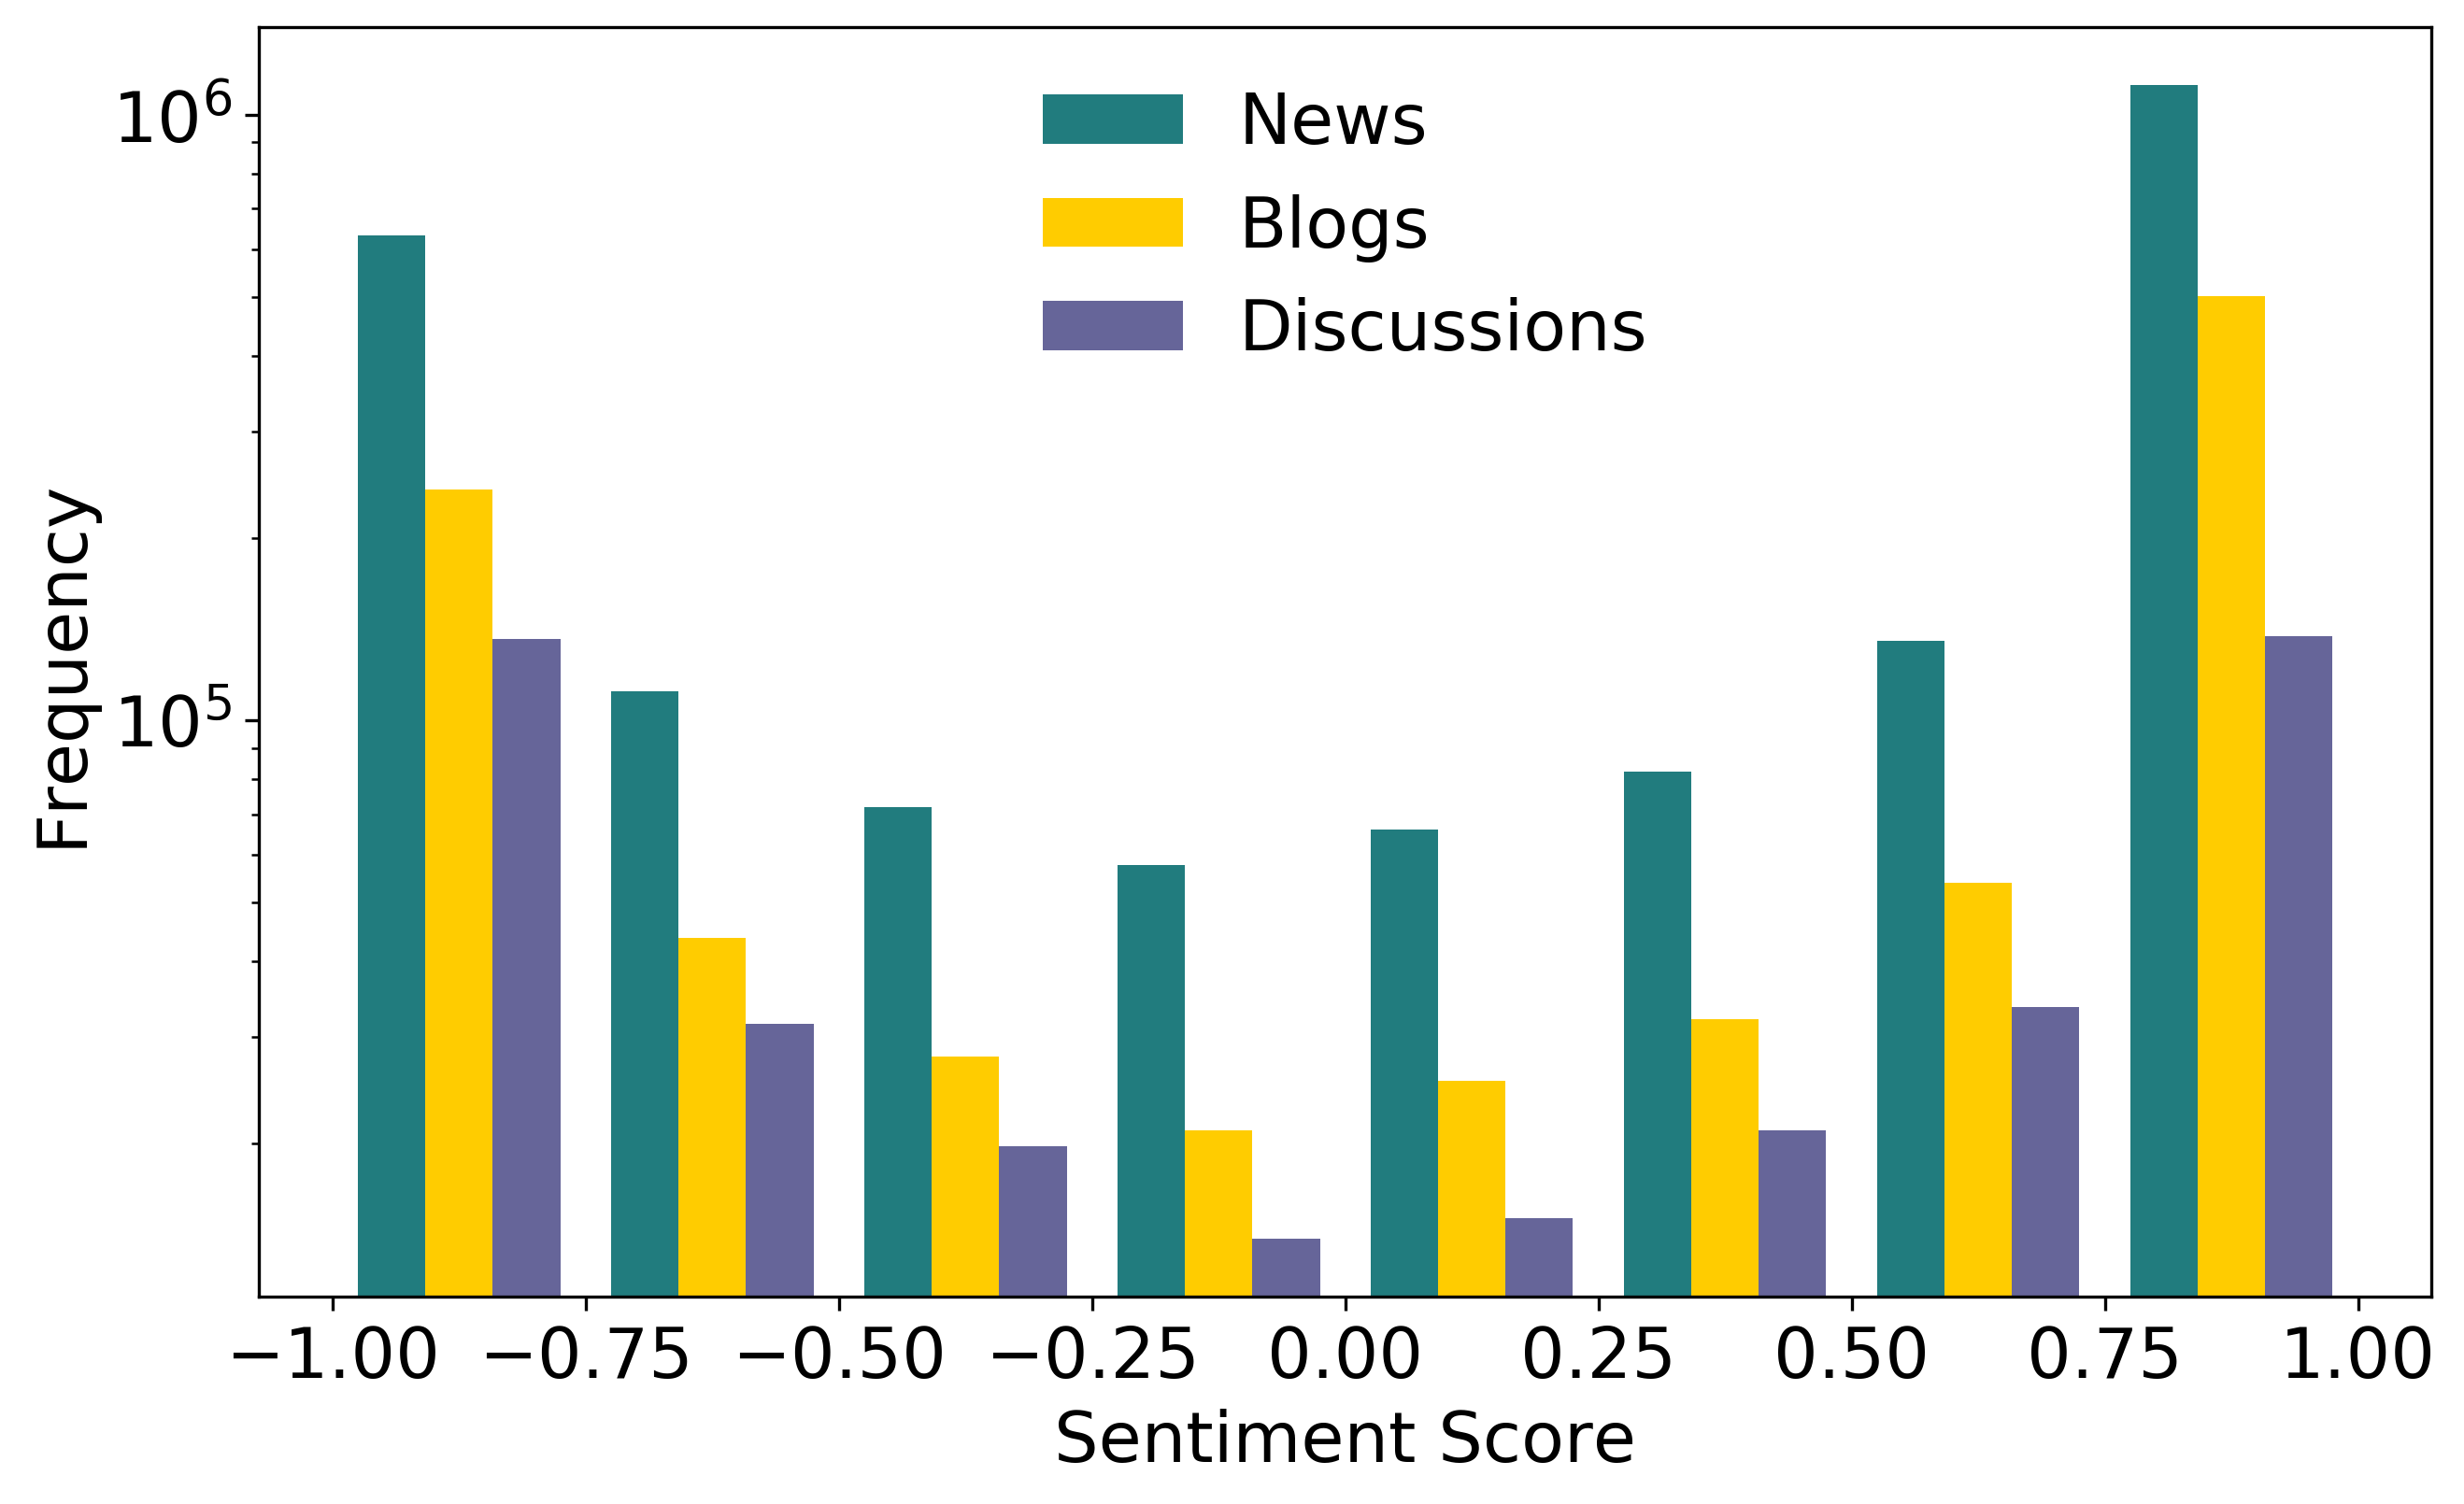

In [11]:
fig = plt.figure(figsize=(10,6), dpi=300)
labels, colors = ['News', 'Blogs', 'Discussions'], [elm, orange, purple]
plt.hist([news['sentiment'], blogs['sentiment'], discussions['sentiment']], 8, histtype='bar', stacked=False, label=labels, color=colors)
plt.legend(loc="upper left")
plt.xlabel("Sentiment Score", fontsize=s)
plt.ylabel("Frequency", fontsize=s)
plt.yscale('log')
plt.xticks(fontsize=s)
plt.yticks(fontsize=s)
plt.legend(loc="best", fontsize=s, frameon=False) 
plt.show()

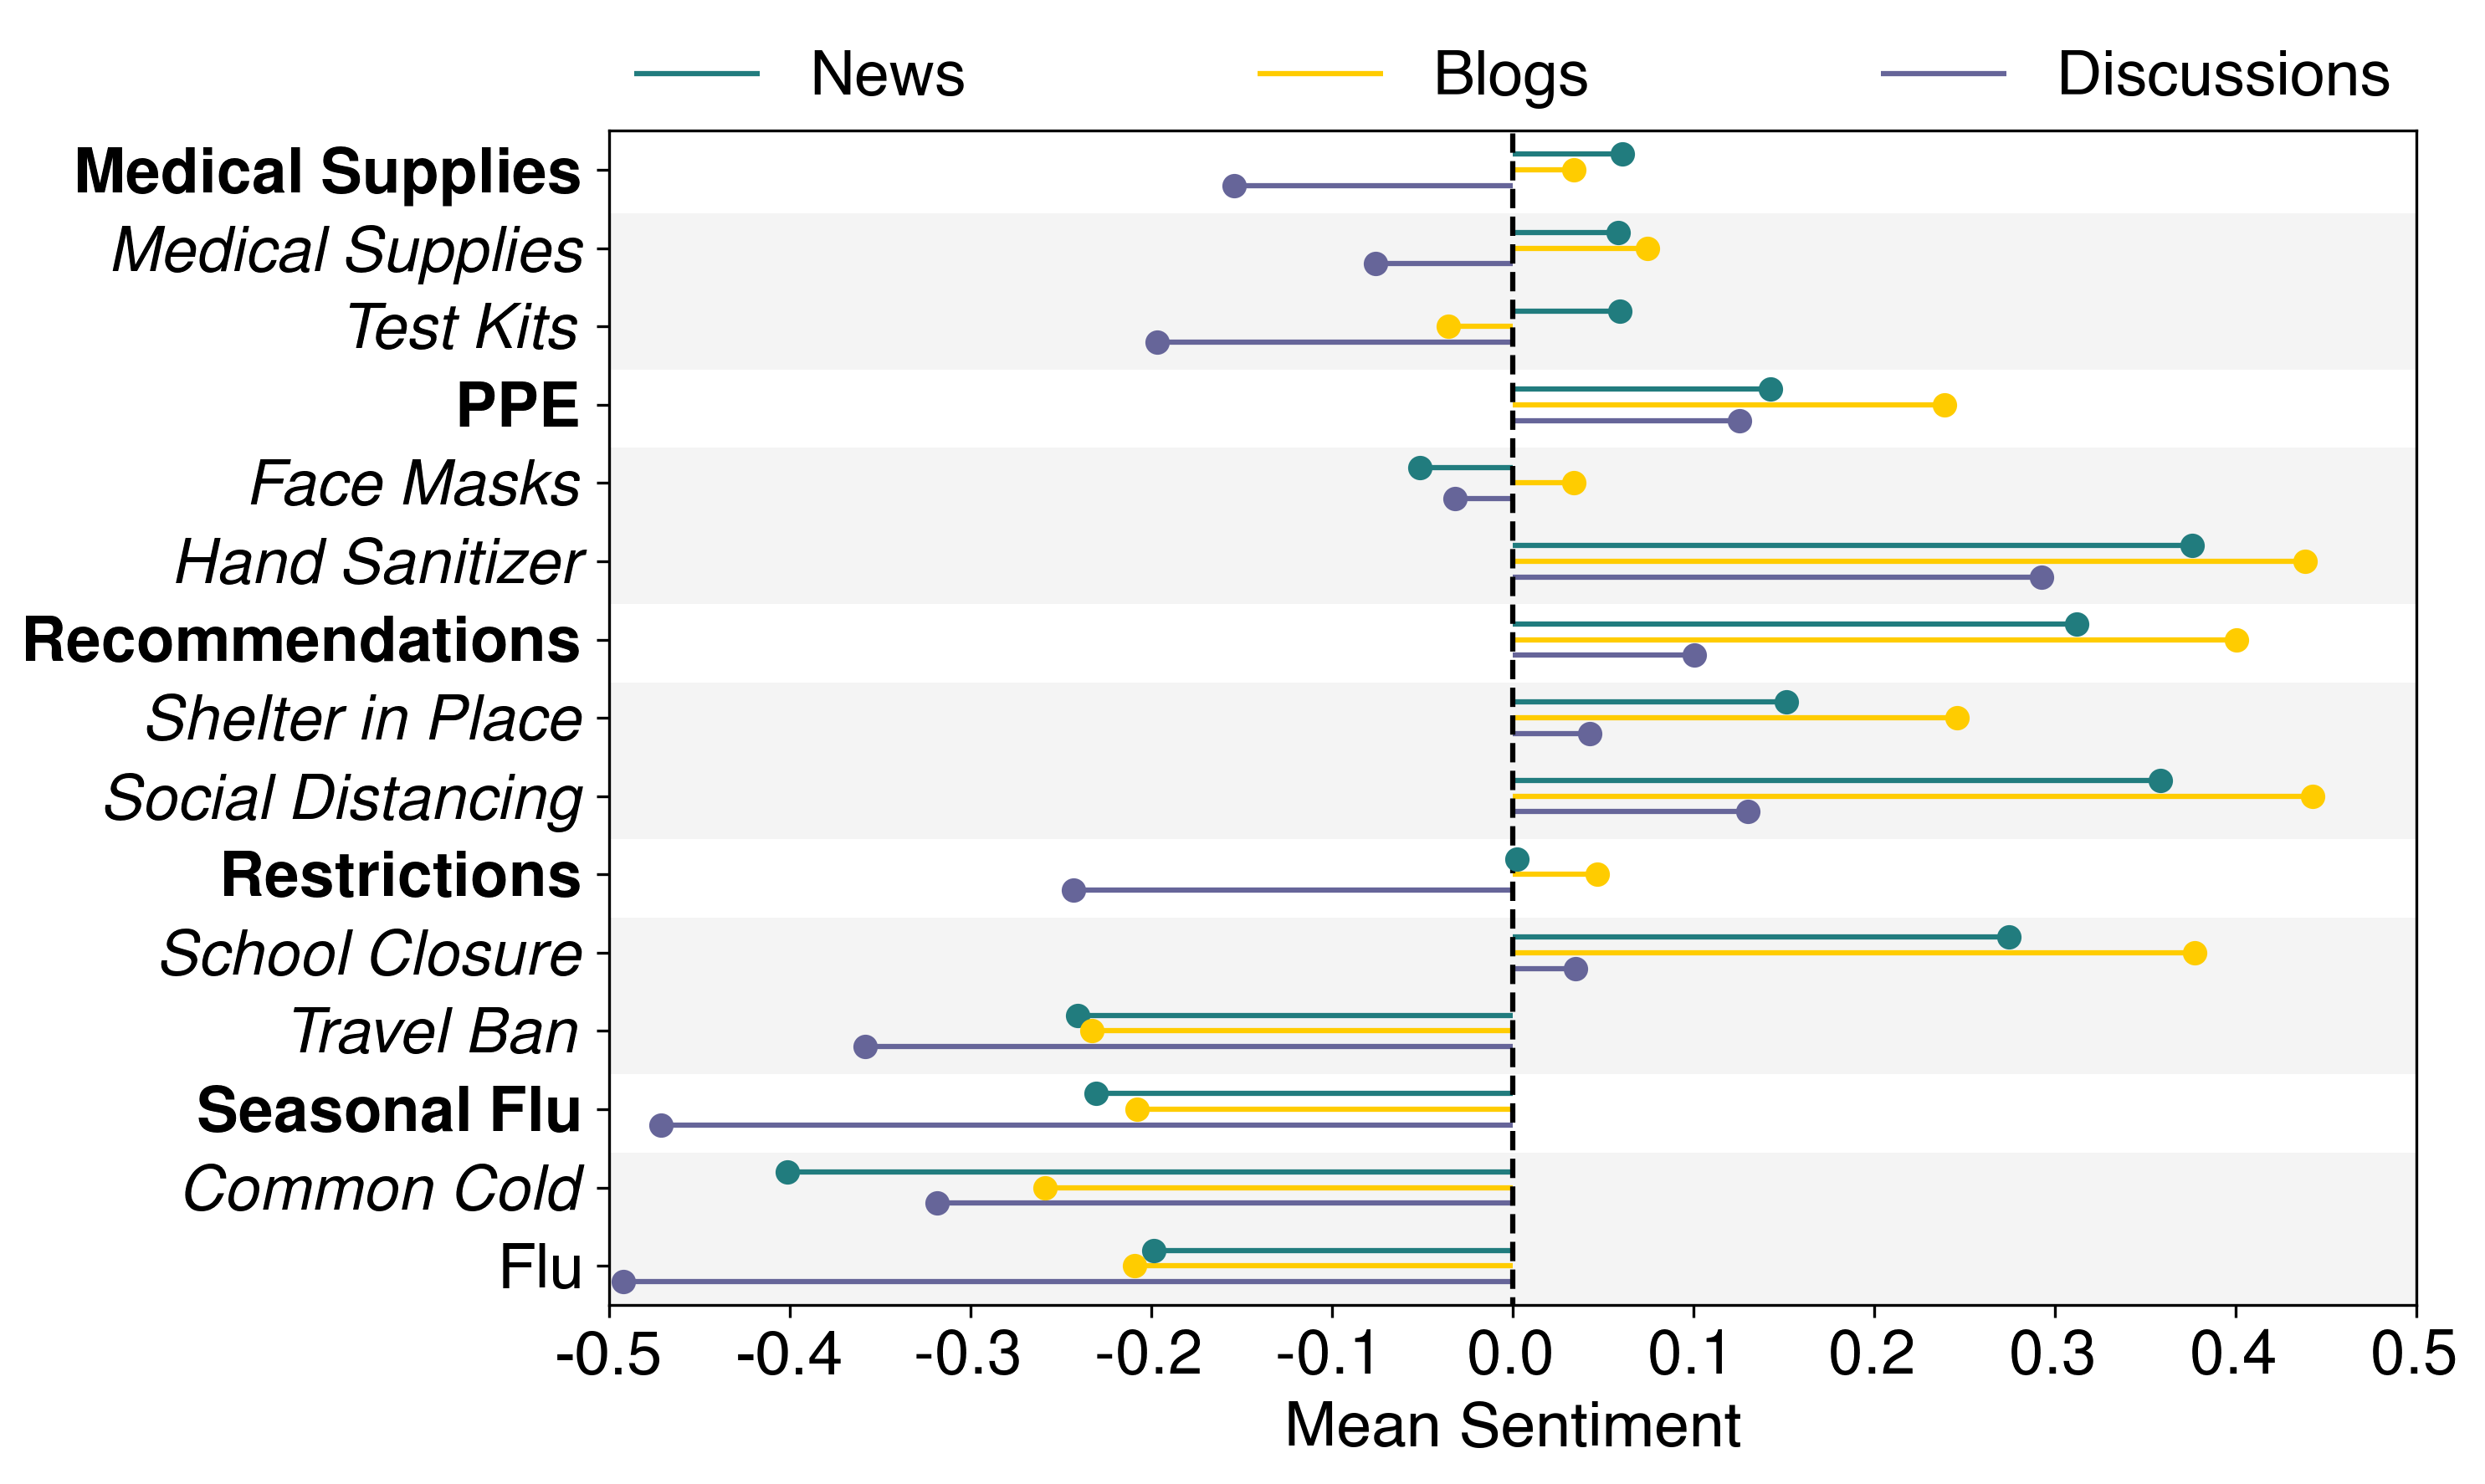

In [12]:
fig = plt.figure(figsize=(10,6), dpi=300)
news_xvalues = sentiment_df[sentiment_df['Source'].str.contains('News')]['Sentiment']
news_yvalues = [round(i,2) for i in sorted(np.arange(1.2,sentiment_df['topics'].nunique()+2,1), reverse=True)]
blogs_xvalues = sentiment_df[sentiment_df['Source'].str.contains('Blogs')]['Sentiment']
blogs_yvalues = [round(i,2) for i in sorted(np.arange(1,sentiment_df['topics'].nunique()+2,1), reverse=True)]
discussions_xvalues = sentiment_df[sentiment_df['Source'].str.contains('Discussions')]['Sentiment']
discussions_yvalues = [round(i,2) for i in sorted(np.arange(.8,sentiment_df['topics'].nunique()+1,1), reverse=True)]

skip = [0,3,6,9,12,15]
for i, values in enumerate(zip(news_xvalues, blogs_xvalues, discussions_xvalues)):
#     if i%3:
        plt.errorbar(x=values[0], y=news_yvalues[i], linestyle='-', fmt='o', c=elm)
        plt.hlines(news_yvalues[i], 0, values[0], color=elm)
        plt.errorbar(x=values[1], y=blogs_yvalues[i], fmt='o', c=orange)
        plt.hlines(blogs_yvalues[i], 0, values[1], color=orange)
        plt.errorbar(x=[values[2]], y=discussions_yvalues[i], fmt='o', c=purple)
        plt.hlines(discussions_yvalues[i], 0, values[2], color=purple)

plt.legend(["News", "Blogs", "Discussions"],bbox_to_anchor=(0., .99, 1., .1), loc=2, ncol=3, mode="expand", borderaxespad=0, fontsize=s, frameon=False)

plt.barh(np.arange(-1,16,1), 
        [-1]*17, 
        height=1.1,
        color= c,
        edgecolor = "none",
       align="center")

plt.barh(np.arange(-1,16,1), 
        [2]*17, 
        height=1.1,
        color= c,
        edgecolor = "none",
       align="center")

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

plt.xticks(np.arange(-.5,.6,.1), fontstyle='normal', fontsize=s)
plt.yticks(np.arange(16), 
           ('', 'Flu', r'\textit{Common  Cold}', r'\textbf{Seasonal Flu}', 
               r'\textit{Travel Ban}', r'\textit{School Closure}', r'\textbf{Restrictions}', 
               r'\textit{Social Distancing}', r'\textit{Shelter in Place}', r'\textbf{Recommendations}', 
               r'\textit{Hand Sanitizer}', r'\textit{Face Masks}', r'\textbf{PPE}', 
               r'\textit{Test Kits}', r'\textit{Medical Supplies}', r'\textbf{Medical Supplies}'), 
           fontsize=s)

plt.ylim(0.5,15.5)
plt.xlim(-.5,.5)

ax = plt.vlines(0, 0, 1000, colors='k', linestyles='dashed')

plt.xlabel("Mean Sentiment", fontsize=s)


plt.tight_layout()
plt.show()